<table>
<tr>
<td>  <img  src="https://raw.githubusercontent.com/Nikoletos-K/pyJedAI/main/documentation/pyjedai.logo.drawio.png?raw=true "style="width: 300px;padding: 40px"/>
</td>
<td> 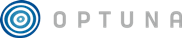 </td>
</tr>
</table>

# DEV | pyJedAI optimization with Optuna

In [1]:
import plotly.express as px
import logging
import sys
import optuna
import plotly
import os
import sys
import pandas as pd
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from optuna.visualization import *

import plotly.io as pio
import plotly.express as px

pio.templates.default = "plotly_white"

## Data Reading

In [2]:
from pyjedai.datamodel import Data

data = Data(
    dataset_1=pd.read_csv("./data/D2/abt.csv", sep='|', engine='python', na_filter=False).astype(str),
    attributes_1=['id','name','description'],
    id_column_name_1='id',
    dataset_2=pd.read_csv("./data/D2/buy.csv", sep='|', engine='python', na_filter=False).astype(str),
    attributes_2=['id','name','description'],
    id_column_name_2='id',
    ground_truth=pd.read_csv("./data/D2/gt.csv", sep='|', engine='python'),
)

data.process()

## WorkFlow

In [3]:
from pyjedai.workflow import WorkFlow, compare_workflows
from pyjedai.block_building import StandardBlocking, QGramsBlocking, ExtendedQGramsBlocking, SuffixArraysBlocking, ExtendedSuffixArraysBlocking
from pyjedai.block_cleaning import BlockFiltering, BlockPurging
from pyjedai.comparison_cleaning import WeightedEdgePruning, WeightedNodePruning, CardinalityEdgePruning, CardinalityNodePruning, BLAST, ReciprocalCardinalityNodePruning, ReciprocalWeightedNodePruning, ComparisonPropagation
from pyjedai.matching import EntityMatching
from pyjedai.clustering import ConnectedComponentsClustering

In [4]:
db_name = "pyjedai"
title = "Test"
storage_name = "sqlite:///{}.db".format(db_name)
study_name = title  # Unique identifier of the study.

In [5]:
'''
 OPTUNA objective function
'''
def objective(trial):
    
    w = WorkFlow(
        block_building = dict(
            method=QGramsBlocking, 
            params=dict(qgrams=trial.suggest_int("qgrams", 3, 10)),
            attributes_1=['name'],
            attributes_2=['name']
        ),
        block_cleaning = [
            dict(
                method=BlockPurging,
                params=dict(smoothing_factor=1.025)
            ),
            dict(
                method=BlockFiltering, 
                params=dict(
                    ratio = trial.suggest_float("ratio", 0.7, 0.95)
                )
            )
        ],
        comparison_cleaning = dict(method=CardinalityEdgePruning),
            entity_matching = dict(
            method=EntityMatching, 
            metric='sorensen_dice',
            similarity_threshold= trial.suggest_float("similarity_threshold", 0.05, 0.9),
            attributes = ['description', 'name']
        ),
        clustering = dict(method=ConnectedComponentsClustering),
        name="Worflow-Test"
    )
    w.run(data, verbose=False)
    f1, precision, recall = w.get_final_scores()
    
    return recall

In [6]:
study_name = title  # Unique identifier of the study.
num_of_trials = 3
study = optuna.create_study(
    directions=["maximize"],
    study_name=study_name,
    storage=storage_name,
    load_if_exists=True
)
print("Optuna trials starting")
study.optimize(
    objective, 
    n_trials=num_of_trials, 
    show_progress_bar=True
)
print("Optuna trials finished")

[I 2022-10-04 19:38:42,750] Using an existing study with name 'Test' instead of creating a new one.


Optuna trials starting


C:\Users\nikol\anaconda3\lib\site-packages\optuna\progress_bar.py:49: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/3 [00:00<?, ?it/s]

[I 2022-10-04 19:39:30,671] Trial 60 finished with value: 99.81412639405205 and parameters: {'qgrams': 3, 'ratio': 0.8055895382279246, 'similarity_threshold': 0.6310895579297189}. Best is trial 8 with value: 100.0.
[I 2022-10-04 19:39:50,936] Trial 61 finished with value: 99.62825278810409 and parameters: {'qgrams': 5, 'ratio': 0.7202942526452295, 'similarity_threshold': 0.3170376358428239}. Best is trial 8 with value: 100.0.
[I 2022-10-04 19:40:00,459] Trial 62 finished with value: 91.82156133828995 and parameters: {'qgrams': 10, 'ratio': 0.7067698351841839, 'similarity_threshold': 0.2052452034411141}. Best is trial 8 with value: 100.0.
Optuna trials finished


# Optuna Visualizations

In [7]:
study.trials_dataframe(attrs=("number", "value", "params", "state"))

number      value  params_qgrams  params_ratio  \
0        0        NaN              5      0.841209   
1        1  92.843866              8      0.741438   
2        2  99.535316              5      0.746788   
3        3  92.843866              9      0.739222   
4        4  94.237918              8      0.843481   
..     ...        ...            ...           ...   
58      58  93.680297              8      0.779276   
59      59        NaN              3      0.756428   
60      60  99.814126              3      0.805590   
61      61  99.628253              5      0.720294   
62      62  91.821561             10      0.706770   

    params_similarity_threshold     state  
0                      0.743463      FAIL  
1                      0.237075  COMPLETE  
2                      0.254821  COMPLETE  
3                      0.076485  COMPLETE  
4                      0.147549  COMPLETE  
..                          ...       ...  
58                     0.460611  COMPLETE  
59                     0.665321      FAIL  
60                     0.631090  COMPLETE  
61                     0.317038  COMPLETE  
62                     0.205245  COMPLETE  

[63 rows x 6 columns]

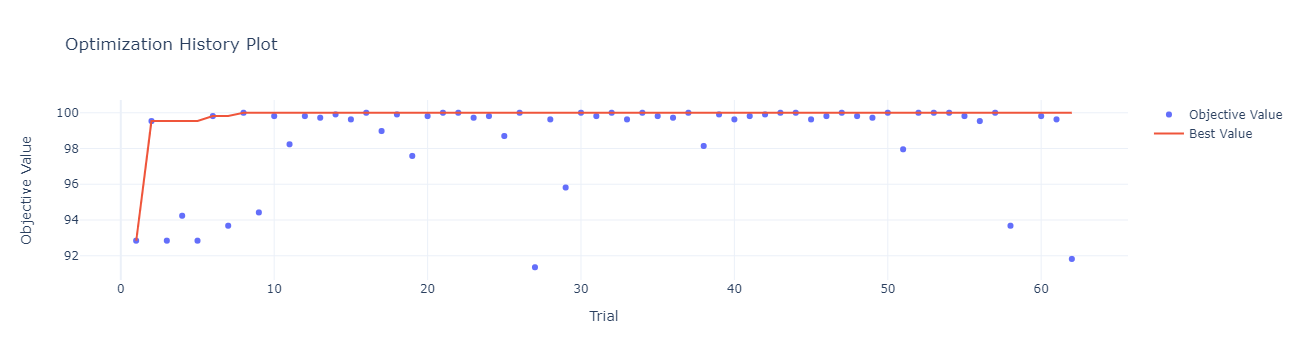

In [8]:
fig = plot_optimization_history(study)
fig.show()

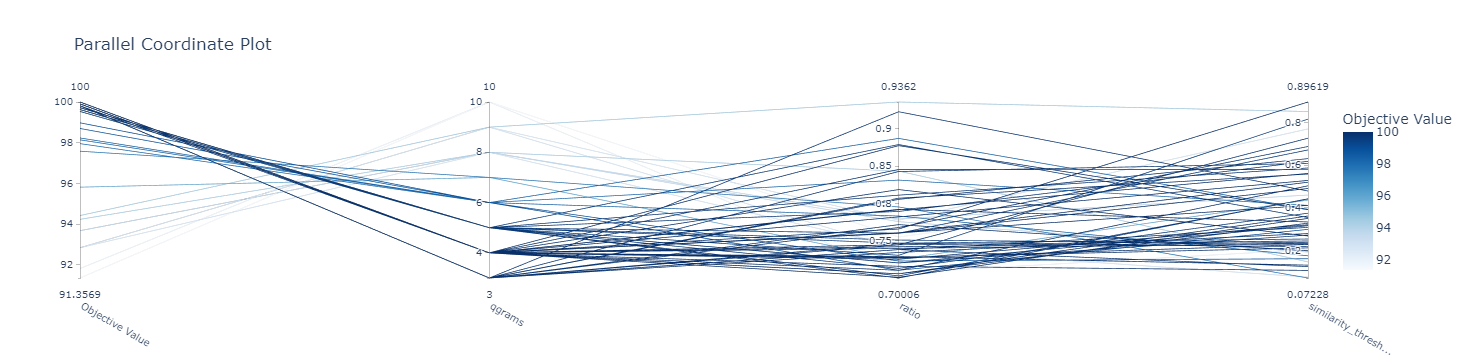

In [9]:
fig = plot_parallel_coordinate(study)
fig.show()

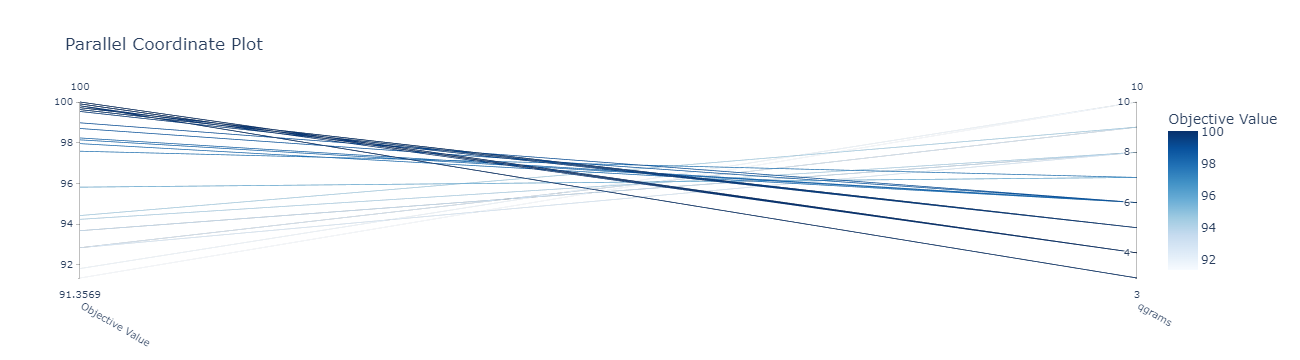

In [10]:
fig = plot_parallel_coordinate(study, params=["qgrams"])
fig.show()

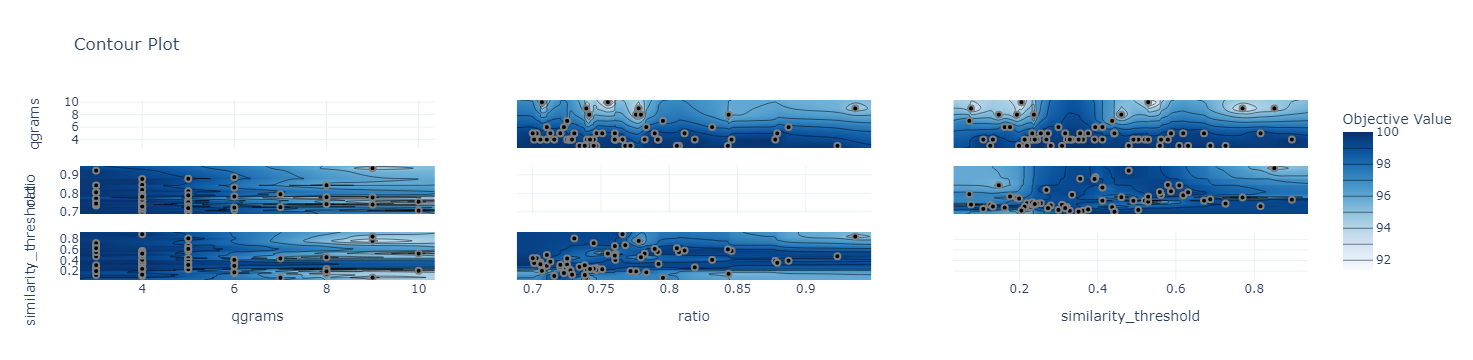

In [11]:
fig = plot_contour(study)
fig.show()

In [ ]:
fig = plot_contour(study, params=["qgrams", "ratio"])
fig.show()

In [ ]:
fig = plot_slice(study,  params=["qgrams", "ratio"])
fig.show()

In [ ]:
fig = plot_slice(study,  params=["qgrams", "ratio"])
fig.show()

In [ ]:
fig = plot_param_importances(study)
fig.show()

In [ ]:
fig = plot_edf(study)
fig.show()

In [ ]:
fig = optuna.visualization.plot_param_importances(
    study, target=lambda t: t.duration.total_seconds(), target_name="duration"
)
fig.show()